# CMM307 - Advanced Artificial Intelligence
### ***(Valentin Kiss - 1608118)***

In [1]:
# Import libraries used throughout the notebook
import re

import pandas as pd
import numpy as np
import nltk

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from lbl2vec import Lbl2Vec

import matplotlib.pyplot as plt

C:\Users\Valentin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-05 10:53:48,473	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Section 1 - Dataset

The selected dataset (AG's News Topic Classification Dataset) is a subset of the AG collection of more than 1 million news articles. This dataset contains 127,600 news articles divide into training and testing sets. The articles are categorized into four distinct classes: Business, Science/Technology, Sports & World which then would present a Multi-Class Text Classification problem. The aim of this project is to implement and evaluate different NLP techniques to process unstructured text data to extract meaningful patterns which then can be used to allocate the corresponding topic to news articles.

### Exploratory Data Analysis

***Load and Explore the dataset***

In [2]:
# Load the train & test datasets into a Pandas DF
train_df = pd.read_csv('./ag_news_data/train.csv')
test_df = pd.read_csv('./ag_news_data/test.csv')

In [3]:
# Output the first few rows in the dataset
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Both datasets contain 3 columns
 * Class Index which is our label which we will try to predict
 * The title of the article
 * The description for the article

In [4]:
# Rename columns
train_df.columns = ['class', 'title', 'description']
test_df.columns = ['class', 'title', 'description']

In [5]:
# Output the shape of both the train and test DFs
print(f'Training data shape: {train_df.shape}')
print(f'Testing data shape: {test_df.shape}')

Training data shape: (120000, 3)
Testing data shape: (7600, 3)


In [6]:
# Output class distribution for train / test data
print(train_df['class'].value_counts())
print(test_df['class'].value_counts())

class
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64
class
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64


* Number of training samples: 120,000
* Number of test samples: 7,600

Both train and test sets are balanced in terms of class labels. 
Class labels range from 1 - 4, representing the four topics

In [7]:
# Check the length of news article descriptions in both train and test sets
print(train_df['description'].apply(len).describe())
print(test_df['description'].apply(len).describe())

count    120000.000000
mean        193.388517
std          64.472066
min           6.000000
25%         155.000000
50%         188.000000
75%         219.000000
max         985.000000
Name: description, dtype: float64
count    7600.000000
mean      192.408026
std        63.192774
min        37.000000
25%       154.000000
50%       187.000000
75%       218.000000
max       830.000000
Name: description, dtype: float64


In [8]:
# Check the length of news article titless in both train and test sets
print(train_df['title'].apply(len).describe())
print(test_df['title'].apply(len).describe())

count    120000.000000
mean         42.071508
std          13.569405
min           6.000000
25%          33.000000
50%          41.000000
75%          49.000000
max         115.000000
Name: title, dtype: float64
count    7600.000000
mean       41.882368
std        13.477635
min         6.000000
25%        33.000000
50%        41.000000
75%        49.000000
max        96.000000
Name: title, dtype: float64


All articles contain data in both their title and their description.

The average length of an article is just below 200 characters. Average lengths for both articles title and description are matched in both test and train sets.

### Text Pre-Processing

In [9]:
# Create the Preprocessing class

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

class BasicPreProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, stem=False, lem=False):
        self.stem = stem
        self.lem = lem
        self.stopwords = stopwords.words('english')
        self.stopwords.extend(['com', 'lt', 'gt', 'quot']) # extend stopwords with words specific to this dataset

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self._preprocess)

    def _preprocess(self, text):
        text = re.sub(r'target=\S+|HREF=\S+', '', text) # remove HREF & Target attributes for URLs
        token_text = word_tokenize(text) # break down text into individual tokens
        normd_text = [token.lower() for token in token_text if token.isalpha()] # convert to lower-case and remove digits & special characters
        swr_text = [token for token in normd_text if token not in self.stopwords] # remove stopwords to keep attention on words that are meaningful

        if self.stem: # if stemming is set to True
            stemmer = SnowballStemmer("english") # instantiate a Snowball Stemmer
            stemmed_text = [stemmer.stem(word) for word in swr_text]
            return ' '.join(stemmed_text) # return the processed text

        if self.lem: # if lemmatization is set to True
            lem = WordNetLemmatizer() # Instantiate a Word Net Lemmatizer
            lemmatized_text = [lem.lemmatize(word) for word in swr_text]
            return ' '.join(lemmatized_text) # return the processed text
            
        return ' '.join(swr_text) # return the processed text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valentin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Use a sample description from the dataset to test the pre-processor
sample_text = ' CHICAGO (Reuters) - Cosmetics manufacturer Estee Lauder  Cos. Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=EL.N target=/stocks/quickinfo/fullquote"&gt;EL.N&lt;/A&gt; on Tuesday posted a bigger quarterly profit,  bolstered by sales in Europe and an improving U.S. retail  market.'

basic_pre_processor = BasicPreProcessor()
lem_pre_processor = BasicPreProcessor(lem=True)
stem_pre_processor = BasicPreProcessor(stem=True)

print(f"Basic Pre-Processing: {basic_pre_processor._preprocess(sample_text)}")
print(f"Lem Pre-Processing: {lem_pre_processor._preprocess(sample_text)}")
print(f"Stem Pre-Processing: {stem_pre_processor._preprocess(sample_text)}")

Basic Pre-Processing: chicago reuters cosmetics manufacturer estee lauder tuesday posted bigger quarterly profit bolstered sales europe improving retail market
Lem Pre-Processing: chicago reuters cosmetic manufacturer estee lauder tuesday posted bigger quarterly profit bolstered sale europe improving retail market
Stem Pre-Processing: chicago reuter cosmet manufactur este lauder tuesday post bigger quarter profit bolster sale europ improv retail market


In [11]:
# Pre-process the texts (title & description) in the training data and save it in add it in a new column
train_df['processed_text'] = lem_pre_processor.fit_transform(train_df['title'] + '. ' + train_df['description'])
train_df.head()

,class,title,description,processed_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bear claw back black reuters reuters wall...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle look toward commercial aerospace reute...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stock outlook reuters reuter...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halt oil export main southern pipeline re...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil price soar record posing new menace u econ...


In [12]:
train_df['processed_text'].apply(len).describe()

count    120000.000000
mean        165.013542
std          43.950606
min           8.000000
25%         137.000000
50%         163.000000
75%         189.000000
max         686.000000
Name: processed_text, dtype: float64

In [13]:
# Pre-process the texts (title & description) in the test data and save it in add it in a new column
test_df['processed_text'] = lem_pre_processor.fit_transform(test_df['title'] + '. ' + test_df['description'])
test_df.head()

,class,title,description,processed_text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fear n pension talk union representing worker ...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",race second private team set launch date human...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,company win grant study peptide ap ap company ...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit help forecast wildfire ap ap b...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aim limit smog ap ap southern california...


## Section 2 - Representation Learning

### TF-IDF 

In [14]:
# First representation - TF-IDF
tfidf_text_representation = Pipeline(
    [
        ('count_vectorizer', CountVectorizer(max_features=400)),
        ('tfidf_transformer', TfidfTransformer())
    ]
)

tfidf_train_repr = tfidf_text_representation.fit_transform(train_df['processed_text']).toarray()

print(tfidf_train_repr)
print(tfidf_train_repr.shape)

tfidf_test_repr = tfidf_text_representation.fit_transform(test_df['processed_text']).toarray()

print(tfidf_test_repr)
print(tfidf_test_repr.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.12446933 0.         0.        ]
 [0.         0.         0.         ... 0.         0.30393102 0.        ]]
(120000, 400)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.28366504 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7600, 400)


**TF-IDF** captures word importance by balancing out their frequency per document and their prevalence across the whole dataset. In the AG's news dataset this can be used to give more weight for topic specific words. 

The TF-IDF pipeline contains:
* CountVectorizer - to convert the pre-processed text into a sparse matrix of token counts, retaining the top 400 most informative terms.
* TfidfTransformer - applies TF-IDF weighting to the token counts to normalize token frequencies and emphasize rare terms.

### Glove Embeddings

In [15]:
# Second representation - Glove

texts = train_df['processed_text']
target = train_df['class']

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1 # calculate the length of the total vocab in the training set
print(vocab_length)

53298


In [16]:
# Glove embeddings - use the pre-trained glove embeddings (with dimensionality of 50) to map words to their corresponding vector
# representations
embeddings_dictionary = dict()
embedding_dim = 50

with open('./glove_pre_trained/glove.6B.50d.txt', encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(53298, 50)

For the second Representation Learning approach, pre-trained **Glove embeddings** are used to derive semantic relationships between words from a co-occurence matrix. The embeddings relate to the probabilities that two words appear next to each other. 

In this case we are using a 50 dimensional vector space, where each dimension corresponds to an aspect of the word's meaning and how they might associate to other words in the corpus. 

The training data contains over 50,000 words, each word (if present) is mapped to their corresponding vector representation in the GLOVE 6B 50D embeddings to create the feature set.

## Section 3 - Baseline Algorithms

### K-Nearest Neighbors (kNN) with TF-IDF

In [17]:
# Train the kNN classifier on the full training set then make prediction on the test set
knn_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(max_features=400)),
    ('tfidf_transformer', TfidfTransformer()),  # Transform counts to TF-IDF
    ('knn_classifier', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

The first baseline algorithm is the **K-Nearest Neighbor**. 

KNN is an instance-based learning algorithm, to classify a new data point, the classifier identifies the 'k' closest training samples based on a distance metric. 

In this case, the KNN is fed the TF-IDF weighted vector representations. KNN then computes similarity between text samples based on their high-dimensional vector representation using 'cosine' similarity. The weight function has been set to 'distance' to give greater influence in voting to neighbors that are closest to the data point. 

### Bidirectional LSTM with Glove Embeddings

In [18]:
longest_train_text = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
print(longest_train_text)

bush visit canada tour u president george bush visiting ottawa today first stop tour take europe early next year first official visit canada since becoming president four year ago skipped canada favour visiting mexico start first term office cancelled state visit canada last year canadian got vocal opposition iraq conflict cbc news report purpose visit may smooth relation damaged war iraq trade dispute canadian beef softwood lumber bush also expected ask martin stronger longer commitment peacekeeping afghanistan help organizing election rebuilding political institution iraq cbc news also speculates bush may offer definitive timetable reopening border canada cattle


In [19]:
len_longest_text = len(word_tokenize(longest_train_text))
print(len_longest_text)

97


In [20]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

train_padded_sentences = pad_sequences(
    embed(texts), 
    len_longest_text, 
    padding='post'
)

print(train_padded_sentences.shape)

test_padded_sentences = pad_sequences(
    embed(test_df['processed_text']), 
    len_longest_text, 
    padding='post'
)

print(test_padded_sentences.shape)

(120000, 97)
(7600, 97)


The Bidirectional LSTM model layers require sequences to have consistent lengths. In this case, sequences are padded to match the length of the longest sequence in the training sample. Matching the longest sequence length to avoid information loss such as if we were to truncate input sequences.

In [21]:
bidirectional_lstm_model = keras.Sequential(
    [
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights= [embedding_matrix]),
        keras.layers.Bidirectional(LSTM(len_longest_text, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(1024, activation='relu'),
        Dropout(0.25),
        Dense(512, activation='relu'),
        Dropout(0.25),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(4, activation='softmax')
    ]
)

bidirectional_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,664,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,664,900 (10.17 MB)

 Trainable params: 2,664,900 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

For the second algorithm, a Bidirectional Long-Short Term Memory (biLSTM) was selected which processes sequential data in both forward and backward directions. LSTM addresses the vanishing gradient limitation of RNNs. Using memory cells and a gating mechanism to selectively retain or forget information over time, allowing the model to capture long-term dependencies in a sequence. 

biLSTM model structure:
* Embedding layer - the pre-trained vector representation of the vocabulary from Glove embeddings
* Bidirectional LSTM layer - to capture contextual dependencies in both forward and backward directions
* GlobalMaxPooling1D layer - to aggregate the most significant features / strongest activations into a single fixed-size vector.
* Dense layers - sets of connected neurons with 'relu' activation function
* Dropout layers - to prevent overfitting, randomly deactivate 25% of neurons during training
* The final output layer with the 'softmax' activation converts the output to a probability distribution for each class label

## Section 4 - Evaluation & Discussion of Results

### Evaluation of the kNN classifier with TF-IDF text representation

In [22]:
# KNeighborsClassifier cross-validation using the training data
accuracy_scores = []

x = train_df['processed_text']
y = train_df['class']

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  knn_pipeline.fit(x_train, y_train)
  predictions = knn_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  accuracy_scores.append(acc)

# print(accuracy_scores)
print(f'Cross-validation mean accuracy score: {np.mean(accuracy_scores):.2f}')

Cross-validation mean accuracy score: 0.76


In [23]:
# KNeighborsClassifier trained on full train data and evaluated on test data

X_train_knn = train_df['processed_text']
y_train_knn = train_df['class']

X_test_knn = test_df['processed_text']
y_test_knn = test_df['class']

knn_pipeline.fit(X_train_knn, y_train_knn)
knn_predictions = knn_pipeline.predict(X_test_knn)

print(classification_report(y_test_knn, knn_predictions))

              precision    recall  f1-score   support

           1       0.83      0.82      0.82      1900
           2       0.82      0.88      0.85      1900
           3       0.82      0.75      0.78      1900
           4       0.77      0.78      0.77      1900

    accuracy                           0.81      7600
   macro avg       0.81      0.81      0.81      7600
weighted avg       0.81      0.81      0.81      7600



* Precision - the accuracy of positive predictions (true positives over all positives predicted)
* Sensitivity (recall) - the true positive rate (ratio of positive instances that are correctly detected)

Results:
* The algorithm best performing for Sci-Tech news (2), classifying with high precision and low false negative rate.
* 'Sports' articles are often - if the model labels something as 'Sports' with high precision, however, it does have the lowest recall, which means many actual 'Sports' news are being misclassified
* The worst performing topic is  'World' (4) with both low precision and recall.

### Evaluation of the Bidirectional LSTM model with Glove embeddings

In [24]:
# Compile and train the bidirectional_lstm model

# Define callback for early stopping
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3, # number of epochs with no improvement
        verbose=1
    )
]

y_train = train_df['class'].apply(lambda x: x - 1).values
y_test = test_df['class'].apply(lambda x: x - 1).values

batch_size = 32
epochs = 10

bidirectional_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = bidirectional_lstm_model.fit(train_padded_sentences, y_train, batch_size=batch_size, epochs=epochs, validation_data=(test_padded_sentences, y_test), callbacks=callbacks)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 225s 59ms/step - accuracy: 0.8629 - loss: 0.4071 - val_accuracy: 0.9092 - val_loss: 0.2734
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 218s 58ms/step - accuracy: 0.9259 - loss: 0.2340 - val_accuracy: 0.9193 - val_loss: 0.2639
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 218s 58ms/step - accuracy: 0.9414 - loss: 0.1807 - val_accuracy: 0.9197 - val_loss: 0.2606
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 223s 59ms/step - accuracy: 0.9525 - loss: 0.1464 - val_accuracy: 0.9178 - val_loss: 0.2681
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 212s 57ms/step - accuracy: 0.9620 - loss: 0.1138 - val_accuracy: 0.9183 - val_loss: 0.3483
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 213s 57ms/step - accuracy: 0.9686 - loss: 0.0936 - val_accuracy: 0.9196 - val_loss: 0.3846
Epoch 6: early stopping


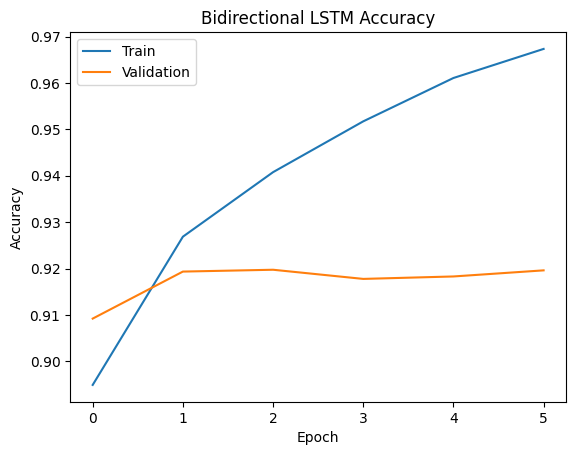

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bidirectional LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training accuracy has continuously increased, while validation accuracy stagnated just below 92% after the second epoch.

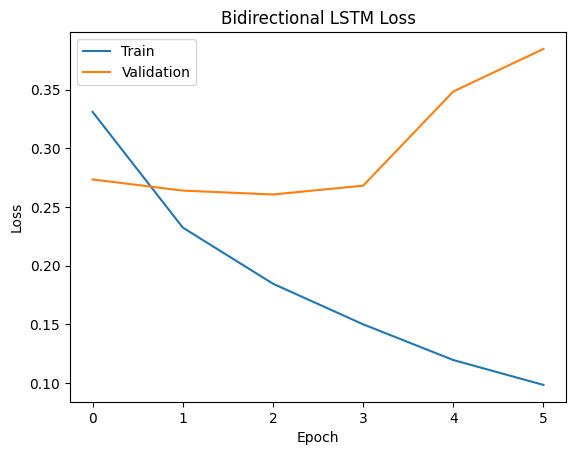

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training loss is continuously decreasing over time while validation loss start to increase slightly at epoch 2 then more significantly. This indicates that although validation accuracy remains the same, the model starting to overfit on the training data after the third epoch.

In [27]:
# Make prediction on the test set using the bidirectional LSTM model
predictions = [np.argmax(i) for i in bidirectional_lstm_model.predict(test_padded_sentences)]
# print(predictions[:5])

bidirectional_lstm_model_acc = accuracy_score(predictions, y_test)
# bidirectional_lstm_model_f1 = f1_score(y_test, predictions, average='micro')

print(f'Bidirectional LSTM Accuracy: {bidirectional_lstm_model_acc}')
# print(f'Bidirectional LSTM F1: {bidirectional_lstm_model_f1}')


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Bidirectional LSTM Accuracy: 0.9196052631578947


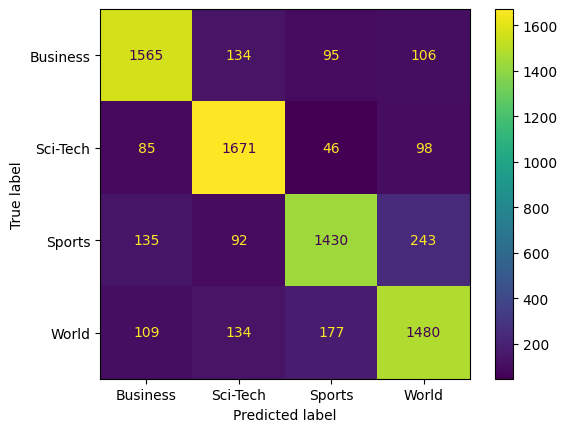

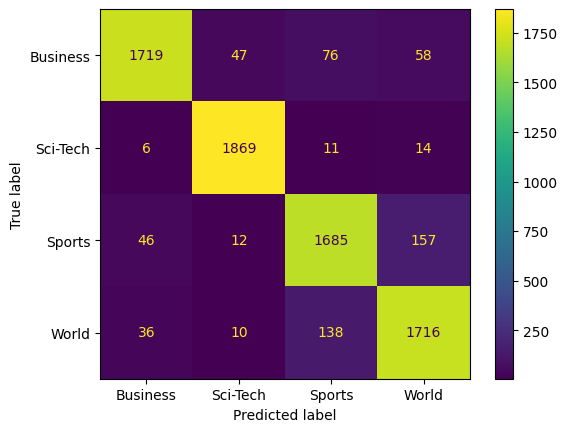

In [28]:
labels = ['Business', 'Sci-Tech', 'Sports', 'World']

disp = ConfusionMatrixDisplay.from_predictions(y_test_knn, knn_predictions, display_labels=labels)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=labels)

As shown above, both models struggled to correctly classify 'Sports' news (Sports often got misclassified as 'Worlds' news and vice-versa for both classifiers), while they were both the most accurate for classifying Sci-Tech articles.

## Section 5 - Paper Overview

Conventional supervised text classification methods typically require a large amount of labelled training data. In contrast, Lbl2Vec introduces an approach that eliminates this dependency by leveraging semantic similarities between documents and predefined keywords describing the semantic boundaries for each topic / label. This ability of Lbl2Vec comes that it automatically generates jointly embedded label (from previously defined keywords representing a topic), document and word vectors. The algorithm captures semantic relationships between documents and labels by computing the label vector & document vector similarities for each label and document vector in the dataset. Based on the results, jointly created embeddings tend to outperfrom previous techniques reliant on statistical embedding approaches. 


This unsupervised approach requires almost no pre-processing of the data – (only lower-casing and tokenisation needed) as well as save annotation costs and reduce the reliance on large-sale labelled datasets while allowing for a highly accurate document classification. 
In case of the AG’s news corpus, there are four rather distinct topics that news articles can belong to which allows for defining unique keywords that are dissimilar from each other and can accurately represent each topic.


Semantic similarities between document and pre-defined keywords are calculated by the model for each topic and threshold are adjusted by a hyperparameter which indicates that this approach could also be extended to multi-label classification problems.  


## Section 6 - Lbl2Vec Implementation

### Data Preparation for Lbl2Vec

In [29]:
# load labels with keywords
labels = pd.read_csv('ag_news_data/labels.csv',sep=';')

# split keywords by separator and save them as array
labels['keywords'] = labels['keywords'].apply(lambda x: x.split(' '))

# convert description keywords to lowercase
labels['keywords'] = labels['keywords'].apply(lambda description_keywords: [keyword.lower() for keyword in description_keywords])

# get number of keywords for each class
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

labels

,class_index,class_name,keywords,number_of_keywords
0,1,World,"[election, state, president, police, politics,...",11
1,2,Sports,"[olympic, football, sport, league, baseball, r...",32
2,3,Business,"[company, market, oil, consumers, exchange, bu...",10
3,4,Science/Technology,"[laboratory, computers, science, technology, w...",18


In [30]:
train_df['data_set_type'] = 'train'
test_df['data_set_type'] = 'test'

full_df = pd.concat([train_df, test_df]).reset_index(drop=True)

full_df.head()

,class,title,description,processed_text,data_set_type
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bear claw back black reuters reuters wall...,train
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle look toward commercial aerospace reute...,train
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stock outlook reuters reuter...,train
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halt oil export main southern pipeline re...,train
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil price soar record posing new menace u econ...,train


In [31]:
# Tag pre-processed documents using TaggedDocument
full_df['tagged_docs'] = full_df.apply(lambda row: TaggedDocument(row['processed_text'].split(' '), [str(row.name)]), axis=1)

In [32]:
# Add 'doc_key' column
full_df['doc_key'] = full_df.index.astype(str)

In [33]:
# Add 'class_name' column
full_df = full_df.merge(labels, left_on='class', right_on='class_index', how='left').drop(['class', 'keywords'], axis=1)

full_df.head()

,title,description,processed_text,data_set_type,tagged_docs,doc_key,class_index,class_name,number_of_keywords
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bear claw back black reuters reuters wall...,train,"([wall, bear, claw, back, black, reuters, reut...",0,3,Business,10
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle look toward commercial aerospace reute...,train,"([carlyle, look, toward, commercial, aerospace...",1,3,Business,10
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stock outlook reuters reuter...,train,"([oil, economy, cloud, stock, outlook, reuters...",2,3,Business,10
3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halt oil export main southern pipeline re...,train,"([iraq, halt, oil, export, main, southern, pip...",3,3,Business,10
4,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil price soar record posing new menace u econ...,train,"([oil, price, soar, record, posing, new, menac...",4,3,Business,10


### Train Lbl2Vec model

In [34]:
# Instantiate and train the model
lbl2vec_model = Lbl2Vec(keywords_list=list(labels['keywords']), tagged_documents=full_df['tagged_docs'][full_df['data_set_type']=='train'], label_names=list(labels['class_name']), similarity_threshold=0.30, min_num_docs=100, epochs=10)
lbl2vec_model.fit()

2024-12-05 11:22:04,858 - Lbl2Vec - INFO - Train document and word embeddings
2024-12-05 11:23:44,576 - Lbl2Vec - INFO - Train label embeddings
2024-12-05 11:23:44,768 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: tickets games
2024-12-05 11:23:44,928 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: consumers stocks
2024-12-05 11:23:45,072 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: computers


## Section 7 - Evaluation of Lbl2Vec

### Evaluation of Lbl2Vec on the test set

In [35]:
test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=full_df['tagged_docs'][full_df['data_set_type']=='test'])
test_docs_lbl_similarities.head()

2024-12-05 11:23:45,894 - Lbl2Vec - INFO - Calculate document embeddings
2024-12-05 11:23:48,985 - Lbl2Vec - INFO - Calculate document<->label similarities


,doc_key,most_similar_label,highest_similarity_score,World,Sports,Business,Science/Technology
0,120000,Business,0.425944,0.411506,0.347328,0.425944,0.410705
1,120001,Science/Technology,0.413281,0.306276,0.351999,0.344057,0.413281
2,120002,Science/Technology,0.410855,0.205383,0.290985,0.368750,0.410855
3,120003,Sports,0.390952,0.253849,0.390952,0.295937,0.344209
4,120004,Science/Technology,0.442541,0.334744,0.261445,0.416213,0.442541


In [36]:
evaluation_test = test_docs_lbl_similarities.merge(full_df[full_df['data_set_type']=='test'], left_on='doc_key', right_on='doc_key')

y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']
print(classification_report(y_true_test, y_pred_test))
print('F1 score:',f1_score(y_true_test, y_pred_test, average='micro'))

                    precision    recall  f1-score   support

          Business       0.77      0.68      0.73      1900
Science/Technology       0.77      0.70      0.73      1900
            Sports       0.86      0.94      0.90      1900
             World       0.78      0.86      0.82      1900

          accuracy                           0.80      7600
         macro avg       0.80      0.80      0.79      7600
      weighted avg       0.80      0.80      0.79      7600

F1 score: 0.7982894736842105


F1 score in paper: 82.7

The results in this project fall behind slightly from the ones published in the paper due to the fact that the same pre-processed text was fed to Lbl2Vec as to the other algorithms described above. These steps do slightly more processing (e.g.: stopword removal, lemmatization) which essentially might have led to losing some information affecting similarities between document <> label vectors.

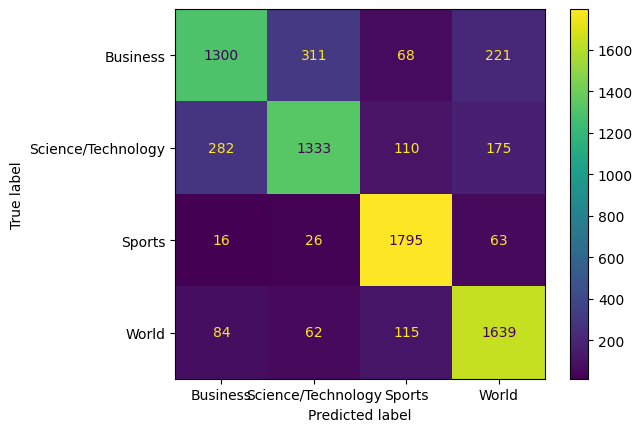

In [37]:
disp = ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test)

As shown in the matrix above, 'Sports' articles have been classified with the highest accuracy followed by 'World'. This suggests that although 'Sports' had almost three times as many keywords defined than 'World', the number of topic-related keywords are not in direct correlation with better results.  

Compared to other models above, Lbl2Vec has been the most accurate for classifying sport articles, which suggests the following:
* Keywords for 'Sport' are more similar to each other, while also being the most dissimilar from other topic keywords.

A similar conclusion can be drawn for the poor performance of 'Business' and 'Science/Technology' classification. As the matrix shows, 'Business' was often mis-classified as 'Science/Technology' and vice versa, which suggests that the keyword dissimilarities for these two topics need to be improved.